In [3]:
#import the library used to query a website
from urllib.request import urlopen
#specify the url
wiki = "https://en.wikipedia.org/wiki/Gal_Gadot"
#Query the website and return the html to the variable 'page'
page = urlopen(wiki)
#import the Beautiful soup functions to parse the data returned from the website
from bs4 import BeautifulSoup
#Parse the html in the 'page' variable, and store it in Beautiful Soup format
soup = BeautifulSoup(page, "lxml")

In [4]:
# find films table
right_table=soup.find('table', class_='wikitable sortable')

Question 1:

In [5]:
import re
#Generate lists
A=[]
B=[]
C=[]
D=[]
moviesLinks=[] #for Question2
year=''
role=''
yearIndex=-1
roleIndex=-1

for row in right_table.findAll("tr"):
    cells = row.findAll('td')
    #all cells
    if len(cells)==5:
        A.append(cells[0].find(text=True))
        B.append(cells[1].find(text=True))
        C.append(cells[2].find(text=True))
        D.append(cells[3].find(text=True))
        #check rowspan
        if cells[0].has_attr('rowspan'):
            year=cells[0].find(text=True)
            yearIndex=int(cells[0].attrs['rowspan'])-1
        if cells[2].has_attr('rowspan'):
            role=cells[2].find(text=True)
            roleIndex=int(cells[2].attrs['rowspan'])-1
        #save link to movie page
        a = cells[1].find_all('a')
        if len(a)>0:
            moviesLinks.append(a[0].get('href'))
    #year or role not exist
    if len(cells)==4:
        #no year
        if yearIndex>0:
            A.append(year)
            yearIndex=yearIndex-1
            B.append(cells[0].find(text=True))
            C.append(cells[1].find(text=True))
            D.append(cells[2].find(text=True))
            #check role rowspan
            if cells[1].has_attr('rowspan'):
                role=cells[1].find(text=True)
                roleIndex=int(cells[1].attrs['rowspan'])-1
            #save link to movie page
            a = cells[0].find_all('a')
            if len(a)>0:
                moviesLinks.append(a[0].get('href'))
        if roleIndex>0:
            A.append(cells[0].find(text=True))
            B.append(cells[1].find(text=True))
            C.append(role)
            D.append(cells[2].find(text=True))
            roleIndex=roleIndex-1
            #check year rowspan
            if cells[0].has_attr('rowspan'):
                year=cells[0].find(text=True)
                yearIndex=int(cells[0].attrs['rowspan'])-1
            #save link to movie page
            a = cells[1].find_all('a')
            if len(a)>0:
                moviesLinks.append(a[0].get('href'))
    #year and role not in row
    if len(cells)==3:
        A.append(year)
        B.append(cells[0].find(text=True))
        C.append(role)
        D.append(cells[1].find(text=True))
        yearIndex=yearIndex-1
        roleIndex=roleIndex-1
        #save link to movie page
        a = cells[0].find_all('a')
        if len(a)>0:
            moviesLinks.append(a[0].get('href'))

In [6]:
#import pandas and convert list to data frame
import pandas as pd
df=pd.DataFrame()
df['Year']=A
df['Title']=B
df['Role']=C
df['Director(s)']=D
df

,Year,Title,Role,Director(s)
0,2009,Fast & Furious,Gisele Yashar,Justin Lin
1,2010,Date Night,Natanya,Shawn Levy
2,2010,Knight and Day,Naomi,James Mangold
3,2011,Fast Five,Gisele Yashar,Justin Lin
4,2013,Fast & Furious 6,Gisele Yashar,Justin Lin
5,2014,Kicking Out Shoshana,Mirit Ben Harush,Shay Kanot
6,2015,Furious 7,Gisele Yashar,James Wan
7,2016,Triple 9,Elena Vlaslov,John Hillcoat
8,2016,Batman v Superman: Dawn of Justice,Diana Prince,Zack Snyder
9,2016,Criminal,Jill Pope,Ariel Vromen


Question 2:

In [7]:
#find all cast
castLinks=[]
#collect all cast members links
for link in moviesLinks:
    moviePage = urlopen("https://en.wikipedia.org"+link)
    movieSoup = BeautifulSoup(moviePage, "lxml")
    if(movieSoup.find(id="Cast")):
        cast=(movieSoup.find(id="Cast").parent).find_next('ul')
    if(movieSoup.find(id="Voice_cast")):
        cast=(movieSoup.find(id="Voice_cast").parent).find_next('ul')
    lines = cast.find_all('li')
    #cast members in different ul
    uls=False
    while (len(lines)==1) and  (cast.find_next('ul')):
        uls=True
        for line in lines:
            a = line.find_all('a')
            if len(a)>0:
                castLinks.append(a[0].get('href'))
        cast=cast.find_next('ul')
        lines = cast.find_all('li')
    #regular
    if uls==False:
        for line in lines:
            a = line.find_all('a')
            if len(a)>0:
                castLinks.append(a[0].get('href'))
# print(castLinks)
print(len(castLinks))

218


Question 3:

In [11]:
#find dups cast members and save count
A=[]
B=[]
C=[]
D=[]
#for question3:
actorName=[]
filmsCount=[]
castCount=dict() #for Question 3 - number of films with gal gadot
for castMember in castLinks:
    if castMember!="/wiki/Gal_Gadot":
        try:
            actorPage = urlopen("https://en.wikipedia.org" + castMember)
            co_actor_soup = BeautifulSoup(actorPage, "lxml")
        except: #page not open
            continue
        co_actor_vcard = co_actor_soup.find("table")
        try:
            co_actor_vcard = co_actor_soup.find("table", class_="infobox biography vcard")
            # name = co_actor_vcard.find(class_="fn")
        except:
            print()
        try:
            if(co_actor_vcard==None):
                co_actor_vcard = co_actor_soup.find("table", class_="infobox vcard plainlist")
            # name = co_actor_vcard.find(class_="fn")
        except:
            print()
        try:
            if(co_actor_vcard==None):
                co_actor_vcard = co_actor_soup.find("table", class_="infobox vcard")
            # name = co_actor_vcard.find(class_="fn")
        except:
            print("ex:  "+castMember)
            continue
        #find name
        if(co_actor_vcard!=None):
            try:
                name = co_actor_vcard.find(class_="fn")
            except:
                name=co_actor_vcard.find('th')
        else:
            print("name prob "+castMember)
            continue
        #dupes - add count
        try:
            nameT=name.text
        except:
            print(castMember +" name prob")
            continue
        if name.text in castCount.keys():
            castCount[name.text]=castCount[name.text]+1
        #first time - save info
        else:
            castCount[name.text]=1                 
            birthday = co_actor_vcard.find(class_="bday")  
            birthplace = co_actor_vcard.find(class_="birthplace")
            try:
                A.append(name.text)
            except:
                A.append("NULL")
            try:
                B.append(birthday.text[:4])
            except:
                B.append("NULL")
            try:
                arr=birthplace.text.split(",")
                length=len(arr)
                C.append(arr[length-1])
            except:
                C.append("NULL")
            awards = 0
            #awards_info=pd.read_html(str(awards_soup.find("table", class_="yes table-2")))[0]
            #awards = (awards_info.loc[awards_info.loc[:, 0] == "Awards won"].loc[:, 1]).values[0]
            #print(awards_info)
            #print(awards)
            # actorName.append(name.text)
            # filmsCount.appenf(castCount[actorLink])
            award_tags = co_actor_soup.find_all("span", string=re.compile(".*award.*"))
            if award_tags:
                award_tag = award_tags[-1]
                awards_table = pd.read_html(str(award_tag.findNext("table")), header=0)[0]
                if awards_table is not None:
                    awards = len(awards_table.index)
                    print(awards)
            else:
                awards = len(co_actor_soup.find_all(class_="yes table-yes2", text='Won\n'))
                if awards == 0:
                    awards_info=pd.read_html(str(co_actor_soup.find("table", class_="yes table-2")))[0]
                        awards = awards_info.loc[awards_info.loc[:, 0]
            print(awards)    

        
                
        
 


IndentationError: unexpected indent (<ipython-input-11-2167c0f62942>, line 90)

In [12]:
# import pandas as pd
df2=pd.DataFrame()
df2['Name']=A
df2['Birth Year']=B
df2['Birth Country']=C
# df2['D']=D
df2=df2.sort_values('Name')
df2







,Name,Birth Year,Birth Country
88,Aaron Paul,1979,U.S.
153,Alan Tudyk,1971,U.S.
18,Alejandro Patino,NULL,NULL
152,Alfred Molina,1953,London
81,Ali Fazal,1986,India
157,Ali Wong,1982,U.S.
112,Alice Eve,1982,England
116,Amaury Nolasco,1970,Puerto Rico
98,Amy Adams,1974,Italy
160,Ana Ortiz,1971,New York


Question 3:

In [57]:
#create data frame and show for each co-actor number of films with gal gadot
coActorsDF=pd.DataFrame()
coActorsDF['Name']=castCount.keys()
coActorsDF['# films with Gal Gadot']=castCount.values()
coActorsDF

,Name,# films with Gal Gadot
0,Vin Diesel,4
1,Paul Walker,4
2,Michelle Rodriguez,3
3,Jordana Brewster,4
4,John Ortiz,2
5,Laz Alonso,1
6,Jack Conley,1
7,Shea Whigham,2
8,Tego Calderón,2
9,Don Omar,1


Text(0,0.5,'Actors Frequency')

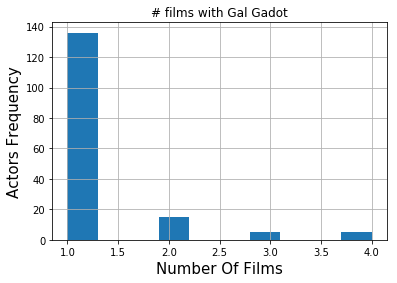

In [71]:
import matplotlib.pyplot as plt
#create histogram
# fig=plt.figure(figsize=(160,5))
fig=coActorsDF.hist(column="# films with Gal Gadot")
plt.xlabel("Number Of Films",fontsize=15)
plt.ylabel("Actors Frequency",fontsize=15)
